In [1]:
# https://github.com/CenturionLC/711-assignment-2

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
import seaborn as sns
import copy
torch.manual_seed(100)


print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(f"CUDA is available: {torch.cuda.is_available()}")
    print(f"Device Name: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")
else:
    print("CUDA is not available")


localFiles = True

gridsearchLE = False
gridsearchSL = False


True
CUDA is available: True
Device Name: NVIDIA GeForce RTX 4060 Laptop GPU
Number of GPUs: 1


In [2]:
def computeDerived(df):
    df['Roundness'] = 4 * df['Area'] / (np.pi * df['Length'] ** 2)
    df['Solidity'] = df['Area'] / df['Area_hull']
    df['Compactness'] = df['Perimeter'] ** 2 / (4 * np.pi * df['Area'])
    df['Aspect_Ratio'] = df['Length'] / df['Width']
    df['Extent'] = df['Area'] / (df['Length']*df['Width'])
    return df;

In [3]:
def welchs_t_test(mu1, sigma1, n1, mu2, sigma2, n2):
    t_stat = (mu1 - mu2) / np.sqrt((sigma1**2 / n1) + (sigma2**2 / n2))
    df = ((sigma1**2 / n1 + sigma2**2 / n2)**2) / \
         (((sigma1**2 / n1)**2) / (n1 - 1) + ((sigma2**2 / n2)**2) / (n2 - 1))
    p_value = 2 * (1 - stats.t.cdf(abs(t_stat), df)) 
    return t_stat, p_value

In [4]:

class NN(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_layers, output_size, device):
        super(NN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        self.layers.append(nn.Linear(input_size, hidden_size))
        self.layers.append(nn.LeakyReLU())

        current_size = hidden_size
        for i in range(hidden_layers):
            next_size = current_size // 2
            if next_size < 1:  
                break
            self.layers.append(nn.Linear(current_size, next_size))
            self.layers.append(nn.LeakyReLU())
            self.layers.append(nn.Dropout(0.2))
            current_size = next_size

        self.layers.append(nn.Linear(current_size, output_size))
        
        self.layers.to(device)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [5]:


df = pd.read_csv('almonds/Almond.csv')

df = df.drop(df.columns[0], axis=1)
df = df.drop(columns=['Eccentricity'])

column_mapping = {
    'Length (major axis)': 'Length',
    'Width (minor axis)': 'Width',
    'Thickness (depth)': 'Thickness',
    'Aspect Ratio': 'Aspect_Ratio',
    'Convex hull(convex area)': 'Area_hull',
}

df.rename(columns=column_mapping, inplace=True)
df.head(15)

,Length,Width,Thickness,Area,Perimeter,Roundness,Solidity,Compactness,Aspect_Ratio,Extent,Area_hull,Type
0,NaN,227.940628,127.759132,22619.0,643.813269,NaN,0.973384,1.458265,NaN,0.681193,23237.5,MAMRA
1,NaN,234.188126,128.199509,23038.0,680.984841,NaN,0.957304,1.601844,NaN,0.656353,24065.5,MAMRA
2,NaN,229.418610,125.796547,22386.5,646.943212,NaN,0.967270,1.487772,NaN,0.683620,23144.0,MAMRA
3,NaN,232.763153,125.918808,22578.5,661.227483,NaN,0.965512,1.540979,NaN,0.685360,23385.0,MAMRA
4,NaN,230.150742,107.253448,19068.0,624.842706,NaN,0.951450,1.629395,NaN,0.714800,20041.0,MAMRA
5,NaN,231.914429,107.759789,19335.0,615.386863,NaN,0.957344,1.558628,NaN,0.727920,20196.5,MAMRA
6,NaN,226.371048,106.479408,18583.5,613.972649,NaN,0.956286,1.614212,NaN,0.727908,19433.0,MAMRA
7,NaN,226.186142,102.623077,18069.5,584.859952,NaN,0.968978,1.506426,NaN,0.740675,18648.0,MAMRA
8,413.477173,NaN,138.190536,41492.0,1078.984843,0.309009,0.950986,2.232834,NaN,0.767645,43630.5,MAMRA
9,418.210327,NaN,129.659897,40630.5,1039.428493,0.295783,0.955888,2.116056,NaN,0.758598,42505.5,MAMRA


In [6]:
missing_values_count = df.isnull().any(axis=1).sum()
print(f"Number of records with missing values: {missing_values_count}")

Number of records with missing values: 2803


In [7]:
# Legacy outlier code

# numerical_df = df.select_dtypes(include=[np.float64])
# categorical_df = df.select_dtypes(exclude=[np.float64])

# z_scores = np.abs(stats.zscore(numerical_df))

# threshold = 3

# # Remove outliers 
# numerical_df = numerical_df[(z_scores < threshold).all(axis=1)]

# categorical_df = categorical_df.loc[numerical_df.index]


# df = pd.concat([numerical_df, categorical_df], axis=1)

In [8]:
numeric_cols = df.select_dtypes(include='number').columns

base_features = ['Area','Thickness', 'Length', 'Width', 'Perimeter', 'Area_hull']
df[base_features] = df[base_features].fillna(df[base_features].mean())

# Recompute Derived
df = computeDerived(df)



types = df['Type'].unique()


X = df.drop('Type', axis=1)

y =  df['Type']

encoder = OneHotEncoder()
y = encoder.fit_transform(y.values.reshape(-1,1)).toarray()

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




In [9]:
df.head(2800)

,Length,Width,Thickness,Area,Perimeter,Roundness,Solidity,Compactness,Aspect_Ratio,Extent,Area_hull,Type
0,290.609274,227.940628,127.759132,22619.0,643.813269,0.341008,0.973384,1.458265,1.274934,0.341462,23237.5,MAMRA
1,290.609274,234.188126,128.199509,23038.0,680.984841,0.347325,0.957304,1.601844,1.240922,0.338509,24065.5,MAMRA
2,290.609274,229.418610,125.796547,22386.5,646.943212,0.337503,0.967270,1.487772,1.266721,0.335775,23144.0,MAMRA
3,290.609274,232.763153,125.918808,22578.5,661.227483,0.340397,0.965512,1.540979,1.248519,0.333789,23385.0,MAMRA
4,290.609274,230.150742,107.253448,19068.0,624.842706,0.287473,0.951450,1.629395,1.262691,0.285091,20041.0,MAMRA
...,...,...,...,...,...,...,...,...,...,...,...,...
2795,290.609274,206.783310,127.363731,20866.0,674.073156,0.314579,0.954441,1.732866,1.405381,0.347228,21862.0,SANORA
2796,290.609274,207.031631,125.491669,20319.5,706.943212,0.306340,0.945511,1.957249,1.403695,0.337728,21490.5,SANORA
2797,290.609274,206.845505,125.980263,20483.5,655.830514,0.308813,0.958494,1.670972,1.404958,0.340760,21370.5,SANORA
2798,290.609274,192.709366,122.356506,18471.5,653.345233,0.278480,0.931000,1.838965,1.508018,0.329830,19840.5,SANORA


In [10]:
# Hyperparameters
input_size = X_train.shape[1]    
hidden_layers = 3
hidden_sizes = 256
learning_rate = 0.001
epochs = 750

output_size = len(df['Type'].unique())    


param_grid = {
    'learning_rate': [0.001,0.005,0.01,0.1],
    'epochs': [250,500,750,1000],
    'hidden_sizes' : [2048,1024,512,256,128],
    'hidden_layers' : [5,4,3,2,1]
}

K_folds = 5
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

criterion = nn.CrossEntropyLoss()

def optimizers(key):
    model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)
    
    optimizers = {
        
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop,
    'Adagrad': optim.Adagrad,
    'Rprop': optim.Rprop,
    }

    return optimizers[key]




activationFunctions = {
    'LeakyRelu': nn.LeakyReLU(),
    'Sigmoid' : nn.Sigmoid(),
}

if(not localFiles): # Set parameters to what was used for gridsearch
    hidden_layers = 3
    hidden_sizes = 256

    learning_rate = 0.001
    epochs = 750




optimizer = optimizers('Adam')



In [11]:
# Dedicated runner for NN
class KFoldExecute:
    def __init__(self, model, criterion, optimizer, kfold, X, y,device,lr=0.001, epochs=10, batch_size=32):
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = model.to(self.device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.kfold = kfold
        self.X = X
        self.y = y
        self.epochs = epochs
        self.lr = lr

        self.fold_losses = []
        self.fold_accuracies = []
        self.epoch_losses = []
        self.epoch_accuracies = []
        self.val_losses = []
        self.val_accuracies = []

    def create_data_loader(self,X, Y,batch_size = 0):
        tensor_X = torch.tensor(X, dtype=torch.float32,device=self.device)
        tensor_Y = torch.tensor(Y, dtype=torch.float32,device=self.device)
        dataset = torch.utils.data.TensorDataset(tensor_X, tensor_Y)
        if batch_size == 0:
            size = len(dataset)
        else: 
            size = batch_size
        return torch.utils.data.DataLoader(dataset,batch_size = size, shuffle=True)
    
    def calculate_accuracy(self,outputs, labels):
        _, predicted = torch.max(outputs, 1)  
        labels = torch.argmax(labels, dim=1)
        correct = (predicted == labels).sum().item()  
        accuracy = correct / labels.size(0)  
        return accuracy

    def train_and_evaluate(self,optimizer,batch_size = 0,verbose=False):
        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(self.X)):
            self.model = NN(input_size, hidden_sizes,hidden_layers, output_size,self.device)
            self.model.to('cuda')
            self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)
            if verbose : 
                print(f'FOLD {fold + 1}')

            X_train_fold = self.X.iloc[train_idx]
            y_train_fold = self.y[train_idx]
            X_val_fold = self.X.iloc[val_idx]
            y_val_fold = self.y[val_idx]

            scaler = StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)

            
            train_loader = self.create_data_loader(X_train_fold, y_train_fold,batch_size)
            val_loader = self.create_data_loader(X_val_fold, y_val_fold,batch_size)
            

            for epoch in range(self.epochs):
                self.model.train()
                    
                
                batch_loss = []
                batch_accuracy = []

                for i, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
    
                    self.optimizer.zero_grad()
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    batch_loss.append(loss.item())
                    loss.backward()
                    self.optimizer.step()
                    
                    accuracy = self.calculate_accuracy(outputs, labels)
                    batch_accuracy.append(accuracy)

                self.epoch_losses.append(np.mean(batch_loss))
                self.epoch_accuracies.append(np.mean(batch_accuracy))

                if verbose and (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {self.epoch_losses[-1]:.4f}, Accuracy: {self.epoch_accuracies[-1]:.4f}')

            self.model.eval()
            val_loss = []
            val_accuracy = []

            with torch.no_grad():
                for i,(inputs, labels) in enumerate(val_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss.append(loss.item())
                    
                    accuracy = self.calculate_accuracy(outputs, labels)
                    val_accuracy.append(accuracy)

            average_val_loss = np.mean(val_loss)
            average_val_accuracy = np.mean(val_accuracy)

            self.fold_losses.append(average_val_loss)
            self.fold_accuracies.append(average_val_accuracy)

            if verbose:
                print(f'Fold {fold + 1} validation loss: {average_val_loss:.4f}, validation accuracy: {average_val_accuracy:.4f}')
            

        if verbose: 
            print('--------------------------------')
        return self.fold_losses,self.fold_accuracies,self.epoch_losses,self.epoch_accuracies

    def evaluate_on_test_set(self, X_test, y_test):
        test_loader = self.create_data_loader(X_test, y_test)
        
        self.model.eval()
        test_loss = 0.0
        test_accuracy = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                test_loss += loss.item()

                accuracy = self.calculate_accuracy(outputs, labels)
                test_accuracy += accuracy

        average_test_loss = test_loss / len(test_loader)
        average_test_accuracy = test_accuracy / len(test_loader)

        return average_test_loss,average_test_accuracy

    def run_batches(self,model,optimizer,X,Y,device,batch_size):
            self.model = NN(input_size, hidden_sizes,hidden_layers, output_size,self.device)
            self.model.to('cuda')
            epoch_losses = []
            epoch_accuracies = []
            self.optimizer = optimizer(self.model.parameters(), lr=learning_rate)

            train_loader = self.create_data_loader(X, Y,batch_size)

            for epoch in range(epochs):
                self.model.train()
                
                batch_loss = []
                batch_accuracy = []

                for i, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
    
                    self.optimizer.zero_grad()
                    loss = self.criterion(outputs, labels)
                    batch_loss.append(loss.item())
                    loss.backward()
                    self.optimizer.step()


                    accuracy = self.calculate_accuracy(outputs, labels)
                    batch_accuracy.append(accuracy)

                epoch_losses.append(np.mean(batch_loss))
                epoch_accuracies.append(np.mean(batch_accuracy))

                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_losses[-1]:.4f}, Accuracy: {epoch_accuracies[-1]:.4f}')


            print('--------------------------------')
            return batch_loss,batch_accuracy,epoch_losses,epoch_accuracies

    
    def train_and_evaluate_H(self,optimizerA,optimizerB,batch_size = 0,verbose=False):
        for fold, (train_idx, val_idx) in enumerate(self.kfold.split(self.X)):
            self.model = NN(input_size, hidden_sizes,hidden_layers, output_size,self.device)
            self.model.to('cuda')
            A_optim = optimizerA(self.model.parameters(), lr=learning_rate)
            B_optim = optimizerB(self.model.parameters(), lr=learning_rate)
            
            if verbose : 
                print(f'FOLD {fold + 1}')

            X_train_fold = self.X.iloc[train_idx]
            y_train_fold = self.y[train_idx]
            X_val_fold = self.X.iloc[val_idx]
            y_val_fold = self.y[val_idx]

            scaler = StandardScaler()
            X_train_fold = scaler.fit_transform(X_train_fold)
            X_val_fold = scaler.transform(X_val_fold)

            
            train_loader = self.create_data_loader(X_train_fold, y_train_fold,batch_size)
            val_loader = self.create_data_loader(X_val_fold, y_val_fold,batch_size)
            

            for epoch in range(self.epochs):
                self.model.train()
                    
                
                batch_loss = []
                batch_accuracy = []

                for i, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
    
                    A_optim.zero_grad()
                    B_optim.zero_grad()

                    
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    batch_loss.append(loss.item())
                    loss.backward()

                    weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            weights.append(param.data.clone())

                    A_optim.step()
                    A_update_weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            A_update_weights.append(param.data - weights[i])
                            param.data = weights[i].clone()
        
                    B_optim.step()
                    B_update_weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            B_update_weights.append(param.data - weights[i])
        
                    AOptim_tweak = 0.8
                    BOptim_tweak = 0.2
        
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            update = AOptim_tweak * A_update_weights[i] + BOptim_tweak * B_update_weights[i]
                            param.data = weights[i] + update
                    
                    
                    accuracy = self.calculate_accuracy(outputs, labels)
                    batch_accuracy.append(accuracy)

                self.epoch_losses.append(np.mean(batch_loss))
                self.epoch_accuracies.append(np.mean(batch_accuracy))

                if verbose and (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch + 1}/{self.epochs}], Loss: {self.epoch_losses[-1]:.4f}, Accuracy: {self.epoch_accuracies[-1]:.4f}')

            self.model.eval()
            val_loss = []
            val_accuracy = []

            with torch.no_grad():
                for i,(inputs, labels) in enumerate(val_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs, labels)
                    val_loss.append(loss.item())
                    
                    accuracy = self.calculate_accuracy(outputs, labels)
                    val_accuracy.append(accuracy)

            average_val_loss = np.mean(val_loss)
            average_val_accuracy = np.mean(val_accuracy)

            self.fold_losses.append(average_val_loss)
            self.fold_accuracies.append(average_val_accuracy)

            if verbose:
                print(f'Fold {fold + 1} validation loss: {average_val_loss:.4f}, validation accuracy: {average_val_accuracy:.4f}')
            

        if verbose: 
            print('--------------------------------')
        return self.fold_losses,self.fold_accuracies,self.epoch_losses,self.epoch_accuracies
        
    def run_batches_H(self,model,optimizerA,optimizerB,X,Y,device,batch_size):
            self.model = NN(input_size, hidden_sizes,hidden_layers, output_size,self.device)
            self.model.to('cuda')
            epoch_losses = []
            epoch_accuracies = []
            A_optim = optimizerA(self.model.parameters(), lr=learning_rate)
            B_optim = optimizerB(self.model.parameters(), lr=learning_rate)

            train_loader = self.create_data_loader(X, Y,batch_size)

            for epoch in range(epochs):
                self.model.train()
                
                batch_loss = []
                batch_accuracy = []

                for i, (inputs, labels) in enumerate(train_loader):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    outputs = self.model(inputs)
    
                    A_optim.zero_grad()
                    B_optim.zero_grad()
                    
                    loss = self.criterion(outputs, labels)
                    batch_loss.append(loss.item())
                    
                    loss.backward()
                    weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            weights.append(param.data.clone())

                    
                    A_optim.step()
                    A_update_weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            A_update_weights.append(param.data - weights[i])
                            param.data = weights[i].clone()
        
                    B_optim.step()
                    B_update_weights = []
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            B_update_weights.append(param.data - weights[i])
        
                    AOptim_tweak = 0.8
                    BOptim_tweak = 0.2
        
                    with torch.no_grad():
                        for i, param in enumerate(self.model.parameters()):
                            update = AOptim_tweak * A_update_weights[i] + BOptim_tweak * B_update_weights[i]
                            param.data = weights[i] + update


                    accuracy = self.calculate_accuracy(outputs, labels)
                    batch_accuracy.append(accuracy)

                epoch_losses.append(np.mean(batch_loss))
                epoch_accuracies.append(np.mean(batch_accuracy))

                if (epoch + 1) % 10 == 0:
                    print(f'Epoch [{epoch + 1}/{epochs}], Loss: {epoch_losses[-1]:.4f}, Accuracy: {epoch_accuracies[-1]:.4f}')


            print('--------------------------------')
            return batch_loss,batch_accuracy,epoch_losses,epoch_accuracies





In [12]:
# Perform gridsearch of hyper parameters
def gridsearchLE(a_list,b_list):
    results = []

    for a, b in product(a_list, b_list):
        print('Hyperparameters:')
        print(f'Learning rate: {a}')
        print(f'Epochs: {b}')

        model = NN(input_size, hidden_sizes,hidden_layers,output_size,device)
        model.to('cuda')
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizers('Adam')

        executor = KFoldExecute(model, criterion, optimizer, kfold, X, y, device, epochs=b, lr=a)

        fold_losses, fold_accuracies, epoch_losses, epoch_accuracies = executor.train_and_evaluate(optimizer)

        average_test_loss = np.mean(fold_losses)
        average_test_accuracy = np.mean(fold_accuracies)
        stdv_test_loss = np.std(fold_losses)
        stdv_test_accuracy = np.std(fold_accuracies)

        print('Results:')
        print(f'Testing loss: {average_test_loss:.4f}, Testing accuracy: {average_test_accuracy:.4f}')
        print('--------------------------------')

        results.append({
            'learning_rate': a,
            'epochs': b,
            'test_loss': average_test_loss,
            'test_accuracy': average_test_accuracy,
            'stdv_test_loss': stdv_test_loss,
            'stdv_test_accuracy': stdv_test_accuracy,
        })

    return results

def gridsearchLS(a_list,b_list):
    results = []

    for a, b in product(a_list, b_list):
        print('Hyperparameters:')
        print(f'Number of hidden layers: {a}')
        print(f'Hidden Layer size: {b}')

        model = NN(input_size, b,a,output_size,device)
        model.to('cuda')
        criterion = nn.CrossEntropyLoss()
        optimizer = optimizers('Adam')

        executor = KFoldExecute(model, criterion, optimizer, kfold, X, y, device, epochs=epochs, lr=learning_rate)

        fold_losses, fold_accuracies, epoch_losses, epoch_accuracies = executor.train_and_evaluate(optimizer)

        average_test_loss = np.mean(fold_losses)
        average_test_accuracy = np.mean(fold_accuracies)
        stdv_test_loss = np.std(fold_losses)
        stdv_test_accuracy = np.std(fold_accuracies)

        print('Results:')
        print(f'Testing loss: {average_test_loss:.4f}, Testing accuracy: {average_test_accuracy:.4f}')
        print('--------------------------------')

        results.append({
            'number_of_hidden_layers': a,
            'hidden_layer_size': b,
            'test_loss': average_test_loss,
            'test_accuracy': average_test_accuracy,
            'stdv_test_loss': stdv_test_loss,
            'stdv_test_accuracy': stdv_test_accuracy,
        })

    return results


In [13]:
kfold = KFold(n_splits=K_folds, shuffle=True, random_state=42)

from itertools import product
learning_rate_list = param_grid['learning_rate']
epochs_list = param_grid['epochs']
hidden_sizes_list = param_grid['hidden_sizes']
hidden_layers_list = param_grid['hidden_layers']


import json

print('Conducting gridsearch with a = learning rate and b = number of epochs')

if(localFiles): 
    with open('resultsLE.json', 'r') as file:
        resultsLE = json.load(file)
else:    
    resultsLE = gridsearchLE(learning_rate_list,epochs_list)
    with open('resultsLE.json', 'w') as f:
        json.dump(resultsLE, f, indent=4)


best_result = max(resultsLE, key=lambda x: x['test_accuracy'])
print('Best Hyperparameters for Learning rate to Epochs:')
print(best_result)
print()    
print('Conducting gridsearch with a = Number of hidden layers and b = Size of hidden layer')

if(localFiles):
    with open('resultsLS.json', 'r') as file:
        resultsLS = json.load(file)
else:
    resultsLS = gridsearchLS(hidden_layers_list,hidden_sizes_list)
    with open('resultsLS.json', 'w') as f:
        json.dump(resultsLS, f, indent=4)


best_result = max(resultsLS, key=lambda x: x['test_accuracy'])
print('Best Hyperparameters for Number of layers to Size of layer:')
print(best_result)



Conducting gridsearch with a = learning rate and b = number of epochs
Best Hyperparameters for Learning rate to Epochs:
{'learning_rate': 0.01, 'epochs': 1000, 'test_loss': 0.6380827188491821, 'test_accuracy': 0.8448013750954928, 'stdv_test_loss': 0.07432601278533542, 'stdv_test_accuracy': 0.010397924722547823}

Conducting gridsearch with a = Number of hidden layers and b = Size of hidden layer
Best Hyperparameters for Number of layers to Size of layer:
{'number_of_hidden_layers': 5, 'hidden_layer_size': 256, 'test_loss': 0.5814752817153931, 'test_accuracy': 0.839449961802903, 'stdv_test_loss': 0.0909778251276592, 'stdv_test_accuracy': 0.010275470637952328}


In [14]:
def generate_row_comparison_table(optimal_index, means, std_devs, index):
    comparison_results = []
    optimal_mean = means[optimal_index]
    optimal_stdv = std_devs[optimal_index]

    for i in range(len(means)):
        if i == optimal_index:
            continue

        t, p = welchs_t_test(means[i], std_devs[i], 5, optimal_mean, optimal_stdv, 5)

        comparison_results.append({
            'Learning rate': index[i],
            'T-Statistic': round(t, 5),
            'P-Value': round(p, 5),
            'Significant': 'Yes' if p < 0.05 else 'No'
        })

    comparison_df = pd.DataFrame(comparison_results)
    return comparison_df
    
def generate_col_comparison_table(optimal_index, means, std_devs, columns):
    comparison_results = []
    optimal_mean = means[optimal_index]
    optimal_stdv = std_devs[optimal_index]

    for i in range(len(means)):
        if i == optimal_index:
            continue

        t, p = welchs_t_test(means[i], std_devs[i], 5, optimal_mean, optimal_stdv, 5)

        comparison_results.append({
            'Epochs': columns[i],
            'T-Statistic': round(t, 5),
            'P-Value': round(p, 5),
            'Significant': 'Yes' if p < 0.05 else 'No'
        })

    comparison_col_df = pd.DataFrame(comparison_results)
    return comparison_col_df

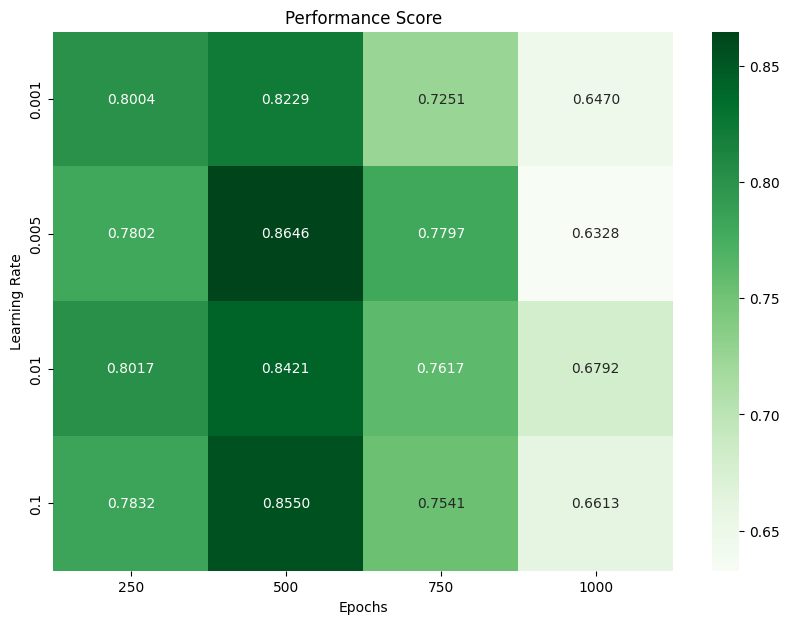

Row-wise Comparison with Optimal Index 0:
   Learning rate  T-Statistic  P-Value Significant
0          0.001     -0.47215  0.64966          No
1          0.005     -0.12917  0.90072          No
2          0.100     -0.16363  0.87416          No

Column-wise Comparison with Optimal Index 0:
   Epochs  T-Statistic  P-Value Significant
0     250     -5.75082  0.00081         Yes
1     750     -7.00742  0.00014         Yes
2    1000    -15.91419  0.00000         Yes


In [15]:

df = pd.DataFrame(resultsLE)

df['normalized_loss'] = (df['test_loss'] - df['test_loss'].min()) / (df['test_loss'].max() - df['test_loss'].min())
df['inverted_loss'] = (1 - df['normalized_loss'])
df['combined_score'] = (df['test_accuracy']*1.5 + df['inverted_loss']*0.5) / 2

heatmap_data = df.groupby(['learning_rate', 'epochs']).agg({'combined_score': 'mean'}).reset_index()
heatmap_data_pivot = heatmap_data.pivot(index='learning_rate', columns='epochs', values='combined_score')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data_pivot, annot=True, fmt=".4f", cmap="Greens")
plt.title('Performance Score')
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.savefig('LearningRate_Epoch_combined_heatmap.png')
plt.show()

heatmap_data['hyperparameter'] = heatmap_data.apply(lambda row: f'LR: {row["learning_rate"]}, Epochs: {row["epochs"]}', axis=1)
labels = heatmap_data['hyperparameter'].tolist()

row_map_pivot = heatmap_data.pivot(index='learning_rate', columns='epochs', values='combined_score')
means = row_map_pivot.mean(axis=1).values  
stdv = row_map_pivot.std(axis=1).values   


comparison_row_df = generate_row_comparison_table(2, means, stdv, row_map_pivot.index)

print("Row-wise Comparison with Optimal Index 0:")
print(comparison_row_df)

col_means = row_map_pivot.mean(axis=0).values

col_stdv = row_map_pivot.std(axis=0).values     



comparison_col_df = generate_col_comparison_table(1, col_means, col_stdv, row_map_pivot.columns)

print("\nColumn-wise Comparison with Optimal Index 0:")
print(comparison_col_df)


In [16]:
def generate_row_comparison_table(optimal_index, means, std_devs, index):
    comparison_results = []
    optimal_mean = means[optimal_index]
    optimal_stdv = std_devs[optimal_index]

    for i in range(len(means)):
        if i == optimal_index:
            continue

        t, p = welchs_t_test(means[i], std_devs[i], 5, optimal_mean, optimal_stdv, 5)

        comparison_results.append({
            'Number of Layers': index[i],
            'T-Statistic': round(t, 5),
            'P-Value': round(p, 5),
            'Significant': 'Yes' if p < 0.05 else 'No'
        })

    comparison_df = pd.DataFrame(comparison_results)
    return comparison_df
    
def generate_col_comparison_table(optimal_index, means, std_devs, columns):
    comparison_results = []
    optimal_mean = means[optimal_index]
    optimal_stdv = std_devs[optimal_index]

    for i in range(len(means)):
        if i == optimal_index:
            continue

        t, p = welchs_t_test(means[i], std_devs[i], 5, optimal_mean, optimal_stdv, 5)

        comparison_results.append({
            'Layer Size': columns[i],
            'T-Statistic': round(t, 5),
            'P-Value': round(p, 5),
            'Significant': 'Yes' if p < 0.05 else 'No'
        })

    comparison_col_df = pd.DataFrame(comparison_results)
    return comparison_col_df

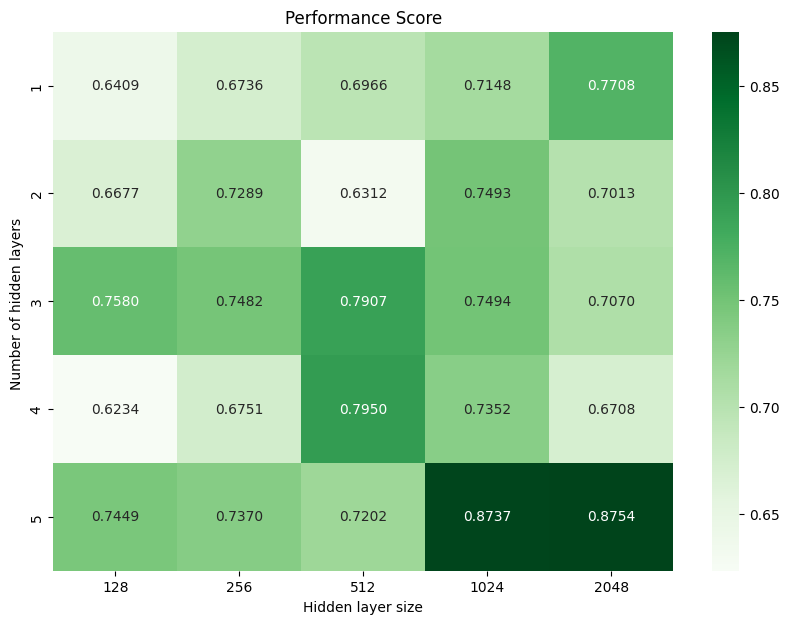

Row-wise Comparison with Optimal Index 0:
   Number of Layers  T-Statistic  P-Value Significant
0                 1     -2.22338  0.06313          No
1                 2     -2.32988  0.05471          No
2                 3     -1.06642  0.33353          No
3                 4     -1.98114  0.08376          No

Column-wise Comparison with Optimal Index 0:
   Layer Size  T-Statistic  P-Value Significant
0         128     -1.98035  0.08303          No
1         256     -1.61097  0.15571          No
2         512     -0.90785  0.39069          No
3        2048     -0.42269  0.68437          No


In [17]:
df = pd.DataFrame(resultsLS)

df['normalized_loss'] = (df['test_loss'] - df['test_loss'].min()) / (df['test_loss'].max() - df['test_loss'].min())
df['inverted_loss'] = (1 - df['normalized_loss'])
df['combined_score'] = (df['test_accuracy']*1.5 + df['inverted_loss']*0.5) / 2

heatmap_data = df.groupby(['number_of_hidden_layers', 'hidden_layer_size']).agg({'combined_score': 'mean'}).reset_index()
heatmap_data_pivot = heatmap_data.pivot(index='number_of_hidden_layers', columns='hidden_layer_size', values='combined_score')

plt.figure(figsize=(10, 7))
sns.heatmap(heatmap_data_pivot, annot=True, fmt=".4f",cmap="Greens")
plt.title('Performance Score')
plt.xlabel('Hidden layer size')
plt.ylabel('Number of hidden layers ')
plt.savefig('Number_of_layers_Hidden_layer_size_combined_heatmap.png')  
plt.show()

heatmap_data['hyperparameter'] = heatmap_data.apply(lambda row: f'LR: {row["number_of_hidden_layers"]}, Epochs: {row["hidden_layer_size"]}', axis=1)
labels = heatmap_data['hyperparameter'].tolist()

row_map_pivot = heatmap_data.pivot(index='number_of_hidden_layers', columns='hidden_layer_size', values='combined_score')
means = row_map_pivot.mean(axis=1).values  

stdv = row_map_pivot.std(axis=1).values   


comparison_row_df = generate_row_comparison_table(4, means, stdv, row_map_pivot.index)

print("Row-wise Comparison with Optimal Index 0:")
print(comparison_row_df)

col_means = row_map_pivot.mean(axis=0).values  

col_stdv = row_map_pivot.std(axis=0).values     



comparison_col_df = generate_col_comparison_table(3, col_means, col_stdv, row_map_pivot.columns)

print("\nColumn-wise Comparison with Optimal Index 0:")
print(comparison_col_df)








In [18]:
# Hyperparameters for Conducting comparisons
hidden_layers = 3
hidden_sizes = 256
learning_rate = 0.001
epochs = 750

In [19]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:
# Running adam model with fixed parameters
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)
optimizer = optimizers('Adam')
executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)



fold_losses_AD,fold_accuracies_AD,epoch_losses_AD,epoch_accuracies_AD  = executor.train_and_evaluate(optimizer,verbose=False)




In [21]:
print('Testing stats:')
print('--------------------------------')
average_test_loss = np.mean(fold_losses_AD)
average_test_accuracy = np.mean(fold_accuracies_AD)
stdv_test_loss = np.std(fold_losses_AD)
stdv_test_accuracy = np.std(fold_accuracies_AD)

print(f'Testing accuracy average: {average_test_accuracy:.4f}')
print(f'Testing accuracy stdv: {stdv_test_accuracy:.4f}')
print(f'Testing loss average: {average_test_loss:.4f}')
print(f'Testing loss stdv: {stdv_test_loss:.4f}')


Testing stats:
--------------------------------
Testing accuracy average: 0.8234
Testing accuracy stdv: 0.0118
Testing loss average: 0.5748
Testing loss stdv: 0.0787


In [22]:
# Run adam with batch
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)
optimizer = optimizers('Adam')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_AD_B,fold_accuracies_AD_B,epoch_losses_AD_B,epoch_accuracies_AD_B  = executor.train_and_evaluate(optimizer,batch_size = 200,verbose=False)


In [23]:
print('Adam batch test done')
average_test_loss = np.mean(fold_losses_AD_B)
average_test_accuracy = np.mean(fold_accuracies_AD_B)
stdv_test_loss = np.std(fold_losses_AD_B)
stdv_test_accuracy = np.std(fold_accuracies_AD_B)

print(f'Testing accuracy average: {average_test_accuracy:.4f}')
print(f'Testing accuracy stdv: {stdv_test_accuracy:.4f}')
print(f'Testing loss average: {average_test_loss:.4f}')
print(f'Testing loss stdv: {stdv_test_loss:.4f}')


Adam batch test done
Testing accuracy average: 0.8383
Testing accuracy stdv: 0.0124
Testing loss average: 0.7384
Testing loss stdv: 0.1220


In [24]:
# Running Rprop model with fixed parameters
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('Rprop')
executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)



fold_losses_RP,fold_accuracies_RP,epoch_losses_RP,epoch_accuracies_RP = executor.train_and_evaluate(optimizer)
print('Testing stats:')
print('--------------------------------')
average_test_loss = np.mean(fold_losses_RP)
average_test_accuracy = np.mean(fold_accuracies_RP)
stdv_test_loss = np.std(fold_losses_RP)
stdv_test_accuracy = np.std(fold_accuracies_RP)


print(f'Testing accuracy average: {average_test_accuracy:.4f}')
print(f'Testing accuracy stdv: {stdv_test_accuracy:.4f}')
print(f'Testing loss average: {average_test_loss:.4f}')
print(f'Testing loss stdv: {stdv_test_loss:.4f}')






Testing stats:
--------------------------------
Testing accuracy average: 0.7545
Testing accuracy stdv: 0.0107
Testing loss average: 0.5882
Testing loss stdv: 0.0313


In [25]:
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('Rprop')
executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_RP_B,fold_accuracies_RP_B,epoch_losses_RP_B,epoch_accuracies_RP_B  = executor.train_and_evaluate(optimizer,batch_size = 200)
print('Rprop batch test done')

Rprop batch test done


In [26]:
# Running RMSprop model with fixed parameters

model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('RMSprop')
executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_RMS,fold_accuracies_RMS,epoch_losses_RMS,epoch_accuracies_RMS = executor.train_and_evaluate(optimizer)





In [27]:
print('Testing stats:')
print('--------------------------------')
average_test_loss = np.mean(fold_losses_RMS)
average_test_accuracy = np.mean(fold_accuracies_RMS)
stdv_test_loss = np.std(fold_losses_RMS)
stdv_test_accuracy = np.std(fold_accuracies_RMS)

print(f'Testing accuracy average: {average_test_accuracy:.4f}')
print(f'Testing accuracy stdv: {stdv_test_accuracy:.4f}')
print(f'Testing loss average: {average_test_loss:.4f}')
print(f'Testing loss stdv: {stdv_test_loss:.4f}')

Testing stats:
--------------------------------
Testing accuracy average: 0.7834
Testing accuracy stdv: 0.0146
Testing loss average: 0.5434
Testing loss stdv: 0.0436


In [28]:
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('RMSprop')
executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_RMS_B,fold_accuracies_RMS_B,epoch_losses_RMS_B,epoch_accuracies_RMS_B  = executor.train_and_evaluate(optimizer,batch_size = 200)
print('RMSProp batch test done')

RMSProp batch test done


In [29]:
# Summary : 

print('Adam')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_AD)
print('Losses',fold_losses_AD)
print('average acc',np.mean(fold_accuracies_AD))
print('average loss',np.mean(fold_losses_AD))
print('stdv acc',np.std(fold_accuracies_AD))
print('stdv loss',np.std(fold_losses_AD))
print('---------------------')


print('RProp')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_RP)
print('Losses',fold_losses_RP)
print('average acc',np.mean(fold_accuracies_RP))
print('average loss',np.mean(fold_losses_RP))
print('stdv acc',np.std(fold_accuracies_RP))
print('stdv loss',np.std(fold_losses_RP))
print('---------------------')

print('RMSProp')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_RMS)
print('Losses',fold_losses_RMS)
print('average acc',np.mean(fold_accuracies_RMS))
print('average loss',np.mean(fold_losses_RMS))
print('stdv acc',np.std(fold_accuracies_RMS))
print('stdv loss',np.std(fold_losses_RMS))
print('---------------------')


Adam
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.8146167557932263), np.float64(0.8377896613190731), np.float64(0.8377896613190731), np.float64(0.8142857142857143), np.float64(0.8125)]
Losses [np.float64(0.5286610722541809), np.float64(0.5268215537071228), np.float64(0.4809761047363281), np.float64(0.6645348072052002), np.float64(0.6731777787208557)]
average acc 0.8233963585434173
average loss 0.5748342633247375
stdv acc 0.011774126059556867
stdv loss 0.07869456446920318
---------------------
RProp
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.7450980392156863), np.float64(0.7486631016042781), np.float64(0.7754010695187166), np.float64(0.7517857142857143), np.float64(0.7517857142857143)]
Losses [np.float64(0.5880155563354492), np.float64(0.5894386768341064), np.float64(0.5397030711174011), np.float64(0.6387073993682861), np.float64(0.5852599740028381)]
average acc 0.7545467277820219
average loss 0.5882249355316163
stdv acc 0.010714893680736777
stdv loss

In [30]:
print('With batches : ')
print('Adam')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_AD_B)
print('Losses',fold_losses_AD_B)
print('average acc',np.mean(fold_accuracies_AD_B))
print('average loss',np.mean(fold_losses_AD_B))
print('stdv acc',np.std(fold_accuracies_AD_B))
print('stdv loss',np.std(fold_losses_AD_B))
print('---------------------')


print('RProp')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_RP_B)
print('Losses',fold_losses_RP_B)
print('average acc',np.mean(fold_accuracies_RP_B))
print('average loss',np.mean(fold_losses_RP_B))
print('stdv acc',np.std(fold_accuracies_RP_B))
print('stdv loss',np.std(fold_losses_RP_B))
print('---------------------')

print('RMSProp')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_RMS_B)
print('Losses',fold_losses_RMS_B)
print('average acc',np.mean(fold_accuracies_RMS_B))
print('average loss',np.mean(fold_losses_RMS_B))
print('stdv acc',np.std(fold_accuracies_RMS_B))
print('stdv loss',np.std(fold_losses_RMS_B))
print('---------------------')

With batches : 
Adam
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.8307660455486543), np.float64(0.8594513457556935), np.float64(0.8453105590062112), np.float64(0.8295833333333333), np.float64(0.8262499999999999)]
Losses [np.float64(0.6915031472841898), np.float64(0.7015242973963419), np.float64(0.6129293342431387), np.float64(0.9719692866007487), np.float64(0.7138660550117493)]
average acc 0.8382722567287784
average loss 0.7383584241072336
stdv acc 0.012445615805284227
stdv loss 0.12203158415732113
---------------------
RProp
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.6674430641821946), np.float64(0.726376811594203), np.float64(0.6844099378881987), np.float64(0.6625000000000001), np.float64(0.6533333333333333)]
Losses [np.float64(0.6979191899299622), np.float64(0.682577649752299), np.float64(0.7059937914212545), np.float64(0.7306285897890726), np.float64(0.7206822633743286)]
average acc 0.678812629399586
average loss 0.7075602968533834
stdv acc 0.025

In [31]:
# Running adam model with fixed parameters and batch size
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('Adam')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

batch_loss,batch_accuracy,epoch_losses_AD,epoch_accuracies_AD = executor.run_batches(model,optimizer,X_train,y_train,device,batch_size = 200)
average_test_loss,average_test_accuracy = executor.evaluate_on_test_set(X_test,y_test)


Epoch [10/750], Loss: 0.7090, Accuracy: 0.6886
Epoch [20/750], Loss: 0.6479, Accuracy: 0.6993
Epoch [30/750], Loss: 0.6026, Accuracy: 0.7336
Epoch [40/750], Loss: 0.5580, Accuracy: 0.7601
Epoch [50/750], Loss: 0.5463, Accuracy: 0.7539
Epoch [60/750], Loss: 0.5129, Accuracy: 0.7732
Epoch [70/750], Loss: 0.4988, Accuracy: 0.7784
Epoch [80/750], Loss: 0.4890, Accuracy: 0.7790
Epoch [90/750], Loss: 0.4556, Accuracy: 0.7947
Epoch [100/750], Loss: 0.4680, Accuracy: 0.7922
Epoch [110/750], Loss: 0.4092, Accuracy: 0.8142
Epoch [120/750], Loss: 0.4185, Accuracy: 0.8104
Epoch [130/750], Loss: 0.4002, Accuracy: 0.8127
Epoch [140/750], Loss: 0.3896, Accuracy: 0.8271
Epoch [150/750], Loss: 0.3814, Accuracy: 0.8270
Epoch [160/750], Loss: 0.3648, Accuracy: 0.8310
Epoch [170/750], Loss: 0.3537, Accuracy: 0.8374
Epoch [180/750], Loss: 0.3247, Accuracy: 0.8504
Epoch [190/750], Loss: 0.3217, Accuracy: 0.8603
Epoch [200/750], Loss: 0.3195, Accuracy: 0.8544
Epoch [210/750], Loss: 0.3158, Accuracy: 0.8615
E

In [32]:
print('Training accuracy : ',np.mean(epoch_accuracies_AD))
print('Testing stats:')
print('--------------------------------')
print('Testing accuracy : ',average_test_accuracy)
print('Testing loss : ',average_test_loss)

Training accuracy :  0.8818817460317461
Testing stats:
--------------------------------
Testing accuracy :  0.8484848484848485
Testing loss :  0.6799470782279968


In [34]:
# Running Rprop model with fixed parameters and batch size
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('Rprop')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

batch_loss,batch_accuracy,epoch_losses_RP,epoch_accuracies_RP = executor.run_batches(model,optimizer,X_train,y_train,device,batch_size = 200)
average_test_loss_RP,average_test_accuracy_RP = executor.evaluate_on_test_set(X_test,y_test)


Epoch [10/750], Loss: 0.7790, Accuracy: 0.6312
Epoch [20/750], Loss: 0.7674, Accuracy: 0.6380
Epoch [30/750], Loss: 0.7656, Accuracy: 0.6366
Epoch [40/750], Loss: 0.7547, Accuracy: 0.6392
Epoch [50/750], Loss: 0.7613, Accuracy: 0.6247
Epoch [60/750], Loss: 0.7718, Accuracy: 0.6380
Epoch [70/750], Loss: 0.7509, Accuracy: 0.6490
Epoch [80/750], Loss: 0.7562, Accuracy: 0.6268
Epoch [90/750], Loss: 0.7571, Accuracy: 0.6381
Epoch [100/750], Loss: 0.7631, Accuracy: 0.6407
Epoch [110/750], Loss: 0.7548, Accuracy: 0.6446
Epoch [120/750], Loss: 0.7373, Accuracy: 0.6565
Epoch [130/750], Loss: 0.7480, Accuracy: 0.6549
Epoch [140/750], Loss: 0.7420, Accuracy: 0.6445
Epoch [150/750], Loss: 0.7431, Accuracy: 0.6480
Epoch [160/750], Loss: 0.7438, Accuracy: 0.6479
Epoch [170/750], Loss: 0.7490, Accuracy: 0.6541
Epoch [180/750], Loss: 0.7559, Accuracy: 0.6597
Epoch [190/750], Loss: 0.7319, Accuracy: 0.6375
Epoch [200/750], Loss: 0.7310, Accuracy: 0.6572
Epoch [210/750], Loss: 0.7462, Accuracy: 0.6523
E

In [35]:
print('Training accuracy : ',np.mean(epoch_accuracies_RP))
print('Testing stats:')
print('--------------------------------')
print('Testing accuracy : ',average_test_accuracy_RP)
print('Testing loss : ',average_test_loss_RP)

Training accuracy :  0.6579905820105819
Testing stats:
--------------------------------
Testing accuracy :  0.6862745098039216
Testing loss :  0.6889883279800415


In [36]:
# Running Rprop model with fixed parameters and batch size
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizer = optimizers('RMSprop')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

batch_loss,batch_accuracy,epoch_losses_RMS,epoch_accuracies_RMS = executor.run_batches(model,optimizer,X_train,y_train,device,batch_size = 200)
average_test_loss_RMS,average_test_accuracy_RMS = executor.evaluate_on_test_set(X_test,y_test)


Epoch [10/750], Loss: 0.6703, Accuracy: 0.7063
Epoch [20/750], Loss: 0.6091, Accuracy: 0.7297
Epoch [30/750], Loss: 0.5700, Accuracy: 0.7488
Epoch [40/750], Loss: 0.5605, Accuracy: 0.7527
Epoch [50/750], Loss: 0.5346, Accuracy: 0.7660
Epoch [60/750], Loss: 0.5135, Accuracy: 0.7747
Epoch [70/750], Loss: 0.5061, Accuracy: 0.7737
Epoch [80/750], Loss: 0.4802, Accuracy: 0.7819
Epoch [90/750], Loss: 0.4689, Accuracy: 0.7803
Epoch [100/750], Loss: 0.4684, Accuracy: 0.7939
Epoch [110/750], Loss: 0.4374, Accuracy: 0.8046
Epoch [120/750], Loss: 0.4189, Accuracy: 0.8130
Epoch [130/750], Loss: 0.4139, Accuracy: 0.8042
Epoch [140/750], Loss: 0.4150, Accuracy: 0.7993
Epoch [150/750], Loss: 0.4141, Accuracy: 0.8098
Epoch [160/750], Loss: 0.3764, Accuracy: 0.8308
Epoch [170/750], Loss: 0.3641, Accuracy: 0.8333
Epoch [180/750], Loss: 0.3549, Accuracy: 0.8336
Epoch [190/750], Loss: 0.3421, Accuracy: 0.8442
Epoch [200/750], Loss: 0.3385, Accuracy: 0.8472
Epoch [210/750], Loss: 0.3412, Accuracy: 0.8420
E

In [37]:
print('Training accuracy : ',np.mean(epoch_accuracies_RMS))
print('Testing stats:')
print('--------------------------------')
print('Testing accuracy: ',average_test_accuracy_RMS)
print('Testing loss: ',average_test_loss_RMS)

Training accuracy :  0.8729398148148148
Testing stats:
--------------------------------
Testing accuracy:  0.8377896613190731
Testing loss:  0.8665997982025146


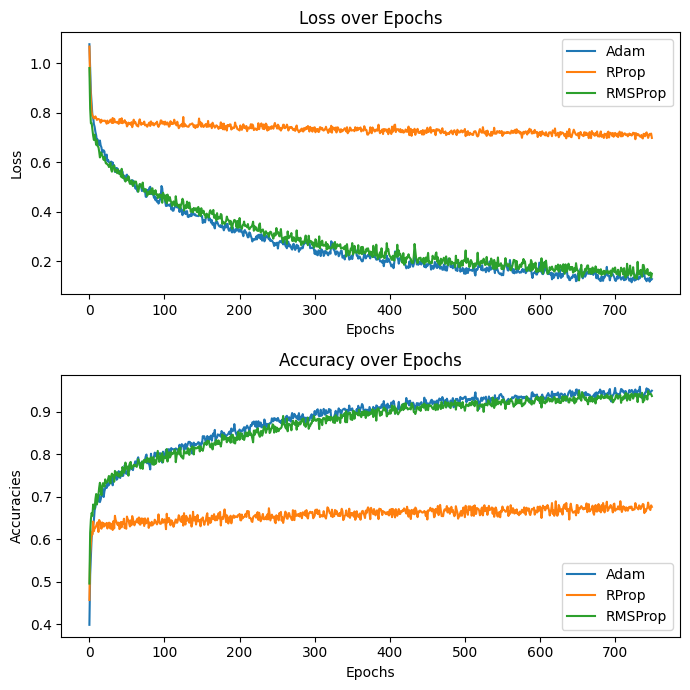

In [39]:

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].plot(range(epochs), epoch_losses_AD, label="Adam")
ax[0].plot(range(epochs), epoch_losses_RP, label="RProp")
ax[0].plot(range(epochs), epoch_losses_RMS, label="RMSProp")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss over Epochs")
ax[0].legend()  

ax[1].plot(range(epochs), epoch_accuracies_AD, label="Adam")
ax[1].plot(range(epochs), epoch_accuracies_RP, label="RProp")
ax[1].plot(range(epochs), epoch_accuracies_RMS, label="RMSProp")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracies")
ax[1].set_title("Accuracy over Epochs")
ax[1].legend() 



plt.tight_layout()
plt.savefig('Gradient Algorithm Visualizations.png')  
plt.show()




In [40]:
# Running Hybrid with batch size
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizerA = optimizers('Adam')
optimizerB = optimizers('Rprop')
optimizerC = optimizers('RMSprop')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)
batch_loss,batch_accuracy,epoch_losses_H,epoch_accuracies_H = executor.run_batches_H(model,optimizerA,optimizerB,X_train,y_train,device,batch_size = 200)
average_test_loss_H,average_test_accuracy_H = executor.evaluate_on_test_set(X_test,y_test)

Epoch [10/750], Loss: 0.7193, Accuracy: 0.6676
Epoch [20/750], Loss: 0.6773, Accuracy: 0.6957
Epoch [30/750], Loss: 0.6096, Accuracy: 0.7354
Epoch [40/750], Loss: 0.5649, Accuracy: 0.7416
Epoch [50/750], Loss: 0.5638, Accuracy: 0.7568
Epoch [60/750], Loss: 0.5288, Accuracy: 0.7663
Epoch [70/750], Loss: 0.5130, Accuracy: 0.7717
Epoch [80/750], Loss: 0.4868, Accuracy: 0.7937
Epoch [90/750], Loss: 0.4687, Accuracy: 0.7945
Epoch [100/750], Loss: 0.4600, Accuracy: 0.7972
Epoch [110/750], Loss: 0.4444, Accuracy: 0.8030
Epoch [120/750], Loss: 0.4346, Accuracy: 0.8077
Epoch [130/750], Loss: 0.4332, Accuracy: 0.8009
Epoch [140/750], Loss: 0.4119, Accuracy: 0.8131
Epoch [150/750], Loss: 0.3789, Accuracy: 0.8360
Epoch [160/750], Loss: 0.4143, Accuracy: 0.8168
Epoch [170/750], Loss: 0.3895, Accuracy: 0.8184
Epoch [180/750], Loss: 0.3686, Accuracy: 0.8279
Epoch [190/750], Loss: 0.3488, Accuracy: 0.8441
Epoch [200/750], Loss: 0.3518, Accuracy: 0.8464
Epoch [210/750], Loss: 0.3404, Accuracy: 0.8470
E

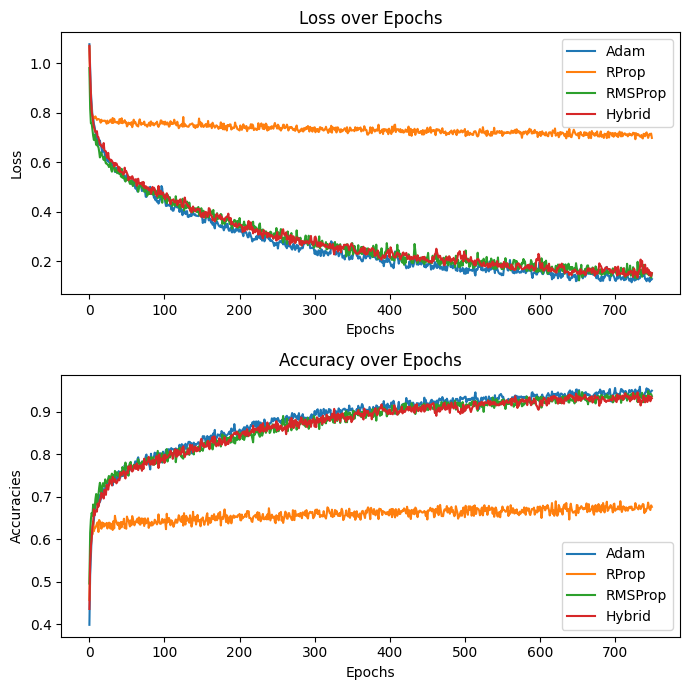

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))

ax[0].plot(range(epochs), epoch_losses_AD, label="Adam")
ax[0].plot(range(epochs), epoch_losses_RP, label="RProp")
ax[0].plot(range(epochs), epoch_losses_RMS, label="RMSProp")
ax[0].plot(range(epochs), epoch_losses_H, label="Hybrid")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss over Epochs")
ax[0].legend()  

ax[1].plot(range(epochs), epoch_accuracies_AD, label="Adam")
ax[1].plot(range(epochs), epoch_accuracies_RP, label="RProp")
ax[1].plot(range(epochs), epoch_accuracies_RMS, label="RMSProp")
ax[1].plot(range(epochs), epoch_accuracies_H, label="Hybrid")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracies")
ax[1].set_title("Accuracy over Epochs")
ax[1].legend() 



plt.tight_layout()
plt.savefig('Hybrid Visualizations batch.png')  
plt.show()

In [42]:
# Running Hybrid model with fixed parameters full batch
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizerA = optimizers('Adam')
optimizerB = optimizers('Rprop')
optimizerC = optimizers('RMSprop')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_H,fold_accuracies_H,epoch_losses_H,epoch_accuracies_H = executor.train_and_evaluate_H(optimizerA,optimizerB,verbose=True)
# average_test_loss_H,average_test_accuracy_H = executor.evaluate_on_test_set(X_test,y_test)

FOLD 1
Epoch [10/750], Loss: 1.0207, Accuracy: 0.5219
Epoch [20/750], Loss: 0.8253, Accuracy: 0.6039
Epoch [30/750], Loss: 0.7197, Accuracy: 0.6793
Epoch [40/750], Loss: 0.6482, Accuracy: 0.7177
Epoch [50/750], Loss: 0.6042, Accuracy: 0.7373
Epoch [60/750], Loss: 0.5788, Accuracy: 0.7493
Epoch [70/750], Loss: 0.5475, Accuracy: 0.7578
Epoch [80/750], Loss: 0.5454, Accuracy: 0.7556
Epoch [90/750], Loss: 0.5162, Accuracy: 0.7765
Epoch [100/750], Loss: 0.5097, Accuracy: 0.7819
Epoch [110/750], Loss: 0.5034, Accuracy: 0.7814
Epoch [120/750], Loss: 0.5006, Accuracy: 0.7895
Epoch [130/750], Loss: 0.4754, Accuracy: 0.7971
Epoch [140/750], Loss: 0.4639, Accuracy: 0.7966
Epoch [150/750], Loss: 0.4693, Accuracy: 0.7997
Epoch [160/750], Loss: 0.4338, Accuracy: 0.8189
Epoch [170/750], Loss: 0.4453, Accuracy: 0.8051
Epoch [180/750], Loss: 0.4387, Accuracy: 0.8091
Epoch [190/750], Loss: 0.4366, Accuracy: 0.8104
Epoch [200/750], Loss: 0.4138, Accuracy: 0.8225
Epoch [210/750], Loss: 0.4041, Accuracy: 0

In [46]:
print('Hybrid without')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_H)
print('Losses',fold_losses_H)
print('average acc',np.mean(fold_accuracies_H))
print('average loss',np.mean(fold_losses_H))
print('stdv acc',np.std(fold_accuracies_H))
print('stdv loss',np.std(fold_losses_H))
print('---------------------')

Hybrid without
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.8484848484848485), np.float64(0.8449197860962567), np.float64(0.8520499108734403), np.float64(0.8285714285714286), np.float64(0.8303571428571429)]
Losses [np.float64(0.6228922605514526), np.float64(0.6524763703346252), np.float64(0.5755830407142639), np.float64(0.7761268615722656), np.float64(0.7015625238418579)]
average acc 0.8408766233766235
average loss 0.6657282114028931
stdv acc 0.009603664895808333
stdv loss 0.06871483345351365
---------------------


In [47]:
# Running Hybrid model with fixed parameters and batch size
model = NN(input_size, hidden_sizes,hidden_layers, output_size,device)

optimizerA = optimizers('Adam')
optimizerB = optimizers('Rprop')
optimizerC = optimizers('RMSprop')

executor = KFoldExecute(model, criterion, optimizer, kfold, X, y,device,epochs=epochs,lr=learning_rate)

fold_losses_H_B,fold_accuracies_H_B,epoch_losses_H_B,epoch_accuracies_H_B = executor.train_and_evaluate_H(optimizerA,optimizerB,batch_size = 200,verbose=True)
# average_test_loss_H_B,average_test_accuracy_H_B = executor.evaluate_on_test_set(X_test,y_test)

FOLD 1
Epoch [10/750], Loss: 0.7102, Accuracy: 0.6616
Epoch [20/750], Loss: 0.6255, Accuracy: 0.7265
Epoch [30/750], Loss: 0.5908, Accuracy: 0.7411
Epoch [40/750], Loss: 0.5501, Accuracy: 0.7477
Epoch [50/750], Loss: 0.5404, Accuracy: 0.7656
Epoch [60/750], Loss: 0.5470, Accuracy: 0.7534
Epoch [70/750], Loss: 0.4995, Accuracy: 0.7802
Epoch [80/750], Loss: 0.4674, Accuracy: 0.7859
Epoch [90/750], Loss: 0.4646, Accuracy: 0.7889
Epoch [100/750], Loss: 0.4491, Accuracy: 0.8053
Epoch [110/750], Loss: 0.4487, Accuracy: 0.7950
Epoch [120/750], Loss: 0.4236, Accuracy: 0.8099
Epoch [130/750], Loss: 0.4106, Accuracy: 0.8167
Epoch [140/750], Loss: 0.4002, Accuracy: 0.8202
Epoch [150/750], Loss: 0.3871, Accuracy: 0.8266
Epoch [160/750], Loss: 0.3611, Accuracy: 0.8446
Epoch [170/750], Loss: 0.3704, Accuracy: 0.8355
Epoch [180/750], Loss: 0.3687, Accuracy: 0.8343
Epoch [190/750], Loss: 0.3716, Accuracy: 0.8321
Epoch [200/750], Loss: 0.3482, Accuracy: 0.8522
Epoch [210/750], Loss: 0.3133, Accuracy: 0

In [48]:
print('Hybrid with')
print('Run 1, Run 2 , Run 3 , Run 4 , Run 5')
print('Accuracies',fold_accuracies_H_B)
print('Losses',fold_losses_H_B)
print('average acc',np.mean(fold_accuracies_H_B))
print('average loss',np.mean(fold_losses_H_B))
print('stdv acc',np.std(fold_accuracies_H_B))
print('stdv loss',np.std(fold_losses_H_B))
print('---------------------')

Hybrid with
Run 1, Run 2 , Run 3 , Run 4 , Run 5
Accuracies [np.float64(0.8449068322981367), np.float64(0.8366252587991717), np.float64(0.8611180124223603), np.float64(0.8375), np.float64(0.8379166666666666)]
Losses [np.float64(0.6363421976566315), np.float64(0.7999668717384338), np.float64(0.7246328592300415), np.float64(1.0371227860450745), np.float64(0.8561876018842062)]
average acc 0.8436133540372669
average loss 0.8108504633108774
stdv acc 0.009238451935580722
stdv loss 0.1350997281789673
---------------------
